In [1]:
import os
import numpy as np
np.random.seed(7)

import sklearn
from sklearn import linear_model
from sklearn.svm import LinearSVC, SVC
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler

import librosa

from tqdm import tqdm_notebook as tqdm

%matplotlib notebook
import matplotlib.pyplot as plt

import pyaudio
import IPython.display as ipd
import time

In [2]:
# ### 1200_logreg_chainsaw_mfcc_13.pkl
# def preprocess(wav):
#     wav = sklearn.preprocessing.maxabs_scale(wav)
#     wav_mfcc = librosa.feature.mfcc(y=wav, n_mfcc=13)
#     wav_mfcc_std = StandardScaler().fit_transform(wav_mfcc)
#     wav_mfcc_std_mean = wav_mfcc_std.mean(axis=1)
    
#     features = np.concatenate([wav_mfcc_std_mean])
#     return features

# ### 1200_logreg_chainsaw_mfcc_logmel_C0.5.pkl
# def preprocess(wav):
#     wav = sklearn.preprocessing.maxabs_scale(wav)
#     wav_mfcc = librosa.feature.mfcc(y=wav, n_mfcc=13)
# #     wav_mfcc_std = StandardScaler().fit_transform(wav_mfcc)
#     wav_mfcc_std_mean = wav_mfcc.mean(axis=1)

#     S = librosa.feature.melspectrogram(wav, n_mels=128)
#     log_S = librosa.amplitude_to_db(S) 
# #     log_S_std = StandardScaler().fit_transform(log_S)
#     log_S_std_mean = log_S.mean(axis=1)
    
#     features = np.concatenate([wav_mfcc_std_mean, log_S_std_mean])
#     return features

# ### 1200_logreg_chainsaw_mfcc_logmel_C0.1_std.pkl
# def preprocess(wav):
#     wav = sklearn.preprocessing.maxabs_scale(wav)
#     wav_mfcc = librosa.feature.mfcc(y=wav, n_mfcc=13)
#     wav_mfcc_std = StandardScaler().fit_transform(wav_mfcc)
#     wav_mfcc_std_mean = wav_mfcc_std.mean(axis=1)

#     S = librosa.feature.melspectrogram(wav, n_mels=128)
#     log_S = librosa.amplitude_to_db(S) 
#     log_S_std = StandardScaler().fit_transform(log_S)
#     log_S_std_mean = log_S_std.mean(axis=1)
    
#     features = np.concatenate([wav_mfcc_std_mean, log_S_std_mean])
#     return features

# ### 1200_logreg_chainsaw_mfcc_logmel_C0.5_64.pkl
# def preprocess(wav):
#     wav = sklearn.preprocessing.maxabs_scale(wav)
#     wav_mfcc = librosa.feature.mfcc(y=wav, n_mfcc=13)
# #     wav_mfcc_std = StandardScaler().fit_transform(wav_mfcc)
#     wav_mfcc_std_mean = wav_mfcc.mean(axis=1)

#     S = librosa.feature.melspectrogram(wav, n_mels=64)
#     log_S = librosa.amplitude_to_db(S) 
# #     log_S_std = StandardScaler().fit_transform(log_S)
#     log_S_std_mean = log_S.mean(axis=1)
    
#     features = np.concatenate([wav_mfcc_std_mean, log_S_std_mean])
#     return features

# ### 1200_logreg_chainsaw_mfcc_logmel_C0.5_32.pkl
# def preprocess(wav):
#     wav = sklearn.preprocessing.maxabs_scale(wav)
#     wav_mfcc = librosa.feature.mfcc(y=wav, n_mfcc=13)
# #     wav_mfcc_std = StandardScaler().fit_transform(wav_mfcc)
#     wav_mfcc_std_mean = wav_mfcc.mean(axis=1)

#     S = librosa.feature.melspectrogram(wav, n_mels=32)
#     log_S = librosa.amplitude_to_db(S) 
# #     log_S_std = StandardScaler().fit_transform(log_S)
#     log_S_std_mean = log_S.mean(axis=1)
    
#     features = np.concatenate([wav_mfcc_std_mean, log_S_std_mean])
#     return features

### 1200_logreg_chainsaw_mfcc_logmel_C0.5_16.pkl
def preprocess(wav):
    wav = sklearn.preprocessing.maxabs_scale(wav)
    wav_mfcc = librosa.feature.mfcc(y=wav, n_mfcc=13)
#     wav_mfcc_std = StandardScaler().fit_transform(wav_mfcc)
    wav_mfcc_std_mean = wav_mfcc.mean(axis=1)

    S = librosa.feature.melspectrogram(wav, n_mels=16)
    log_S = librosa.amplitude_to_db(S) 
#     log_S_std = StandardScaler().fit_transform(log_S)
    log_S_std_mean = log_S.mean(axis=1)
    
    features = np.concatenate([wav_mfcc_std_mean, log_S_std_mean])
    return features

In [3]:
### Load model
clf = joblib.load('1200_logreg_chainsaw_mfcc_logmel_C0.5_16.pkl')

In [4]:
### Record Setting
sr=22050
rec_sec = 5
chunk_size = 4410

<IPython.core.display.Javascript object>


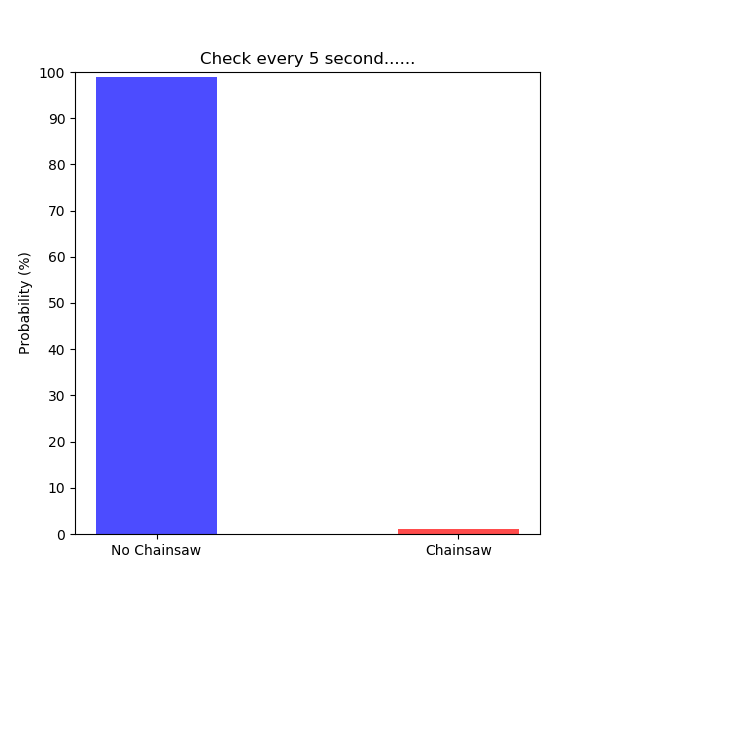

In [ ]:
### Record
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paFloat32, channels=1, rate=sr, input=True, frames_per_buffer=chunk_size)

wav = np.zeros(sr*rec_sec)
threshold = 0.03

# plt.ion()
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
fig.canvas.flush_events()

while True:
    wav[:-chunk_size] = wav[chunk_size:]
    wav[-chunk_size:] = np.frombuffer(stream.read(chunk_size), dtype=np.float32)
#     wav = wav[:sr*sec]

    rms = np.std(wav)
#     print(rms)
    if rms < threshold: 
        plt.clf()
        plt.title('Check every 5 second......')
        plt.bar(['No Chainsaw', 'Chainsaw'], [0.99, 0.01], width=0.4, color=['b', 'r'], alpha=0.7)
        plt.ylim([0,1])
        plt.yticks(np.arange(0, 1.1, step=0.1), np.arange(0, 110, step=10))
        plt.ylabel('Probability (%)')
        fig.canvas.draw()
        continue

    feature = preprocess(wav)
    feature = np.expand_dims(feature, axis=0)
    pred = clf.predict_proba(feature)

    plt.clf()
    plt.title('Check every 5 second......')
    plt.bar(['No Chainsaw', 'Chainsaw'], [pred[0][0], pred[0][1]], width=0.4, color=['b', 'r'], alpha=0.7)
    plt.ylim([0, 1])
    plt.yticks(np.arange(0, 1.1, step=0.1), np.arange(0, 110, step=10))
    plt.ylabel('Probability (%)')
    fig.canvas.draw()
    #     print(pred[0][0] < pred[0][1], pred)

In [ ]:
# close stream
stream.stop_stream()
stream.close()
p.terminate()

In [ ]:
ipd.Audio(wav, rate=sr)